In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df= pd.read_csv('/content/drive/MyDrive/city_temperature.csv')

<ipython-input-3-e11fa80584d4>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('/content/drive/MyDrive/city_temperature.csv')


In [4]:
df.shape

(2906327, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [6]:
df['Region'].unique()

array(['Africa', 'Asia', 'Australia/South Pacific', 'Europe',
       'Middle East', 'North America',
       'South/Central America & Carribean'], dtype=object)

In [7]:
df['Country'].unique()

array(['Algeria', 'Burundi', 'Benin', 'Central African Republic', 'Congo',
       'Egypt', 'Ethiopia', 'Gabon', 'Gambia', 'Guinea', 'Guinea-Bissau',
       'Ivory Coast', 'Kenya', 'Morocco', 'Madagascar', 'Mauritania',
       'Malawi', 'Mozambique', 'Namibia', 'Nigeria', 'Senegal',
       'Sierra Leone', 'South Africa', 'Togo', 'Tunisia', 'Tanzania',
       'Uganda', 'Zambia', 'Bangladesh', 'China', 'Hong Kong', 'India',
       'Indonesia', 'Japan', 'Kazakhstan', 'Kyrgyzstan', 'Laos',
       'Malaysia', 'Mongolia', 'Myanmar (Burma)', 'Nepal', 'North Korea',
       'Pakistan', 'Philippines', 'Singapore', 'South Korea', 'Sri Lanka',
       'Taiwan', 'Tajikistan', 'Thailand', 'Turkmenistan', 'Uzbekistan',
       'Vietnam', 'Australia', 'New Zealand', 'Albania', 'Austria',
       'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
       'Georgia', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Ma

## Jepang

In [8]:
df_japan = df[df['Country']=='Japan']

In [9]:
df_japan.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
358851,Asia,Japan,NaN,Osaka,1,1,1995,42.1
358852,Asia,Japan,NaN,Osaka,1,2,1995,37.6
358853,Asia,Japan,NaN,Osaka,1,3,1995,43.2
358854,Asia,Japan,NaN,Osaka,1,4,1995,46.1
358855,Asia,Japan,NaN,Osaka,1,5,1995,40.9


In [10]:
df_japan.shape

(27798, 8)

In [11]:
df_japan.describe()

,Month,Day,Year,AvgTemperature
count,27798.000000,27798.000000,27798.000000,27798.000000
mean,6.468919,15.717354,2007.188215,55.853471
std,3.457202,8.801199,7.325093,19.751330
min,1.000000,1.000000,1995.000000,-99.000000
25%,3.000000,8.000000,2001.000000,43.900000
50%,6.000000,16.000000,2007.000000,57.200000
75%,9.000000,23.000000,2014.000000,70.000000
max,12.000000,31.000000,2020.000000,93.000000


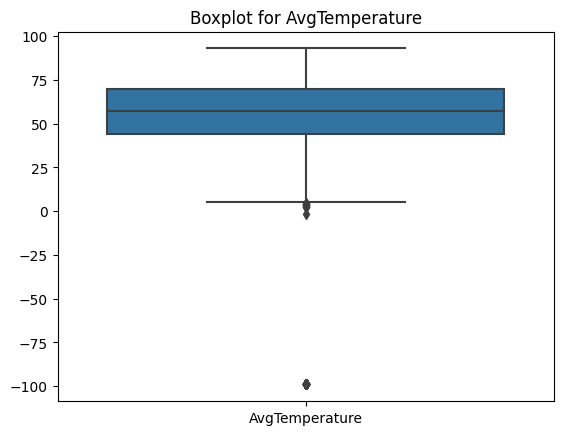

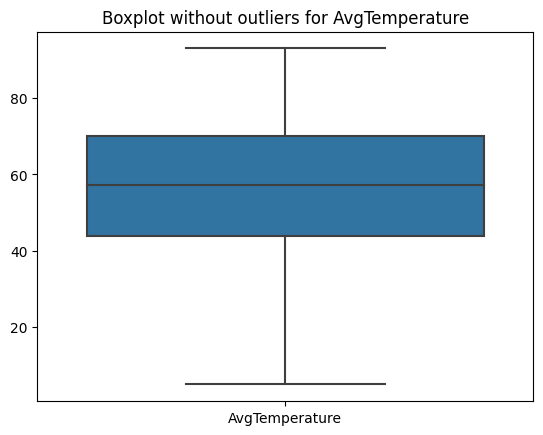

In [12]:
avg_temp = 'AvgTemperature'

sns.boxplot(data=df_japan[[avg_temp]])
plt.title(f'Boxplot for {avg_temp}')
plt.show()

def clean_outliner(data,start_quantile,end_quantile) :
  data = data.copy()
  Q1 = data.quantile(start_quantile)
  Q3 = data.quantile(end_quantile)
  IQR = Q3 - Q1
  return(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 *IQR)

df_clean = df_japan.loc[clean_outliner(df_japan[avg_temp],0.25,0.75)]

sns.boxplot(data=df_clean[[avg_temp]])
plt.title(f'Boxplot without outliers for {avg_temp}')
plt.show()

In [13]:
new_df = df_clean.copy()
new_df['Date'] = pd.to_datetime(df_clean[['Year', 'Month', 'Day']])
new_df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
358851,Asia,Japan,NaN,Osaka,1,1,1995,42.1,1995-01-01
358852,Asia,Japan,NaN,Osaka,1,2,1995,37.6,1995-01-02
358853,Asia,Japan,NaN,Osaka,1,3,1995,43.2,1995-01-03
358854,Asia,Japan,NaN,Osaka,1,4,1995,46.1,1995-01-04
358855,Asia,Japan,NaN,Osaka,1,5,1995,40.9,1995-01-05


In [14]:
final_df = new_df.drop(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year'], axis=1)
final_df = final_df[['Date', 'AvgTemperature']]
final_df.head()

,Date,AvgTemperature
358851,1995-01-01,42.1
358852,1995-01-02,37.6
358853,1995-01-03,43.2
358854,1995-01-04,46.1
358855,1995-01-05,40.9


In [ ]:
fig=plt.figure(figsize=(15,8))
ax=sns.lineplot(data=final_df ,x="Date",y="AvgTemperature")
plt.title("Average Temperature in Japan",size=20,weight="bold")

In [ ]:
X = final_df['AvgTemperature'].values.reshape(-1, 1)
data_train, data_test= train_test_split(X,test_size=0.2,shuffle=False)

In [ ]:
sc = MinMaxScaler()
train_scaled = sc.fit_transform(data_train)
test_scaled = sc.fit_transform(data_test)

In [ ]:
import numpy as np
input_size = 100
def prepare_data(data, input_size):
    X, y = [], []
    for i in range(input_size, len(data)):
        X.append(data[i - input_size:i, 0])
        y.append(data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = prepare_data(train_scaled, input_size)
X_test, y_test = prepare_data(test_scaled, input_size)

In [ ]:
model=Sequential([
    LSTM(64, return_sequences= True ,input_shape =(X_train.shape[1],1)),
    Dropout(0.25),
    LSTM(128, return_sequences= True),
    Dropout(0.25),
    LSTM(256, return_sequences= True),
    Dropout(0.25),
    LSTM(128, return_sequences= True),
    Dropout(0.25),
    LSTM(64),
    Dropout(0.25),
    Dense(1)
])
model.summary()

In [ ]:
X_scaled = sc.fit_transform(X)

class MAEThresholdCallback(Callback):
    def __init__(self, threshold):
        super(MAEThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):
      if (logs.get('mae') <= threshold_mae) and (logs.get('val_mae') <= threshold_mae):
          print("\nReached 90% accuracy, stopping training")
          self.model.stop_training = True

threshold_mae = (X_scaled.max() - X_scaled.min()) * 5 / 100
mae_threshold_callback = MAEThresholdCallback(threshold_mae)

In [ ]:
callbacks = [
    EarlyStopping(monitor='mae', patience=7, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='mae', save_best_only=True, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.000001, verbose=1),
    mae_threshold_callback
]

model.compile(loss=tf.keras.losses.Huber(),optimizer=Adam(learning_rate=0.0001),metrics= ["mae"])

In [ ]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=100,
    callbacks=callbacks,
    batch_size=32
)

In [ ]:
# Plot MAE (Mean Absolute Error)
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()